In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras import regularizers

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

print(tf.__version__)

1.15.0


Using TensorFlow backend.


In [2]:
raw_dataset = pd.read_csv("Hotel Data\H1.csv")

dataset = raw_dataset.copy()
dataset.head(10)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,0,0,2015,July,27,1,0,2,2,0,...,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,0,9,2015,July,27,1,0,2,2,0,...,No Deposit,303,NULL,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,1,85,2015,July,27,1,0,3,2,0,...,No Deposit,240,NULL,0,Transient,82.0,0,1,Canceled,2015-05-06
9,1,75,2015,July,27,1,0,3,2,0,...,No Deposit,15,NULL,0,Transient,105.5,0,0,Canceled,2015-04-22


In [3]:
dataset.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
      dtype='object')

In [4]:
dataset.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

### Ordering the months

In [36]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
dataset['ArrivalDateMonth'] = pd.Categorical(dataset['ArrivalDateMonth'], categories=months, ordered=True)

### Distribution of marketSegment with respect to ADR count

,ADR
MarketSegment,
Complementary,201
Corporate,2309
Direct,6513
Groups,5836
Offline TA/TO,7472
Online TA,17729


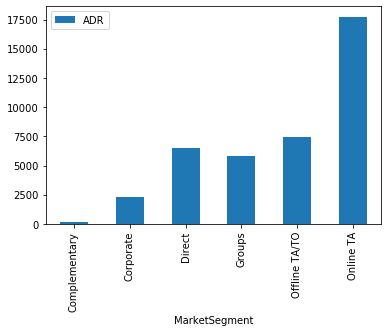

In [37]:
p_table1 = dataset.pivot_table( index = ['MarketSegment'], values = "ADR", aggfunc='count')
p_table1.plot(kind='bar')
p_table1

### Representing Customertype variation for each marketSegment

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000262A02EFF28>,
      dtype=object)

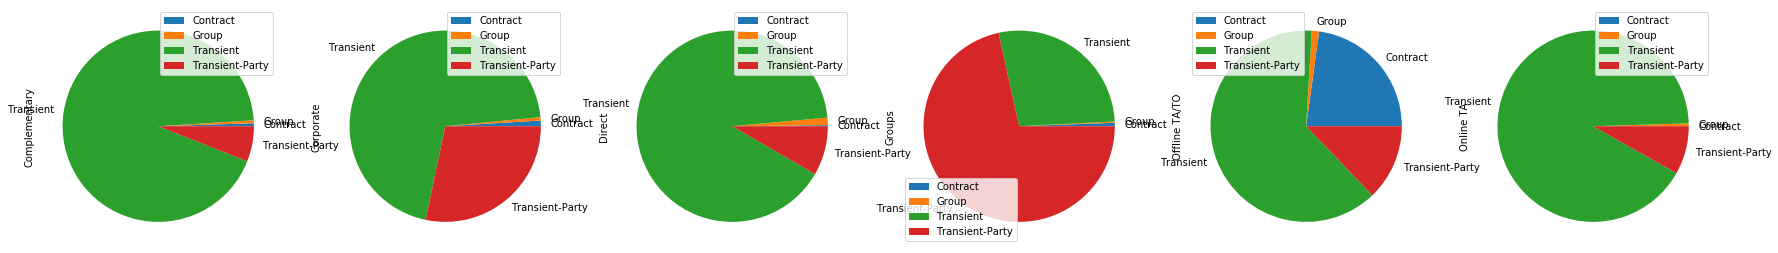

In [9]:
p_table2 = dataset.pivot_table( index = ['CustomerType'], aggfunc='count', values='ADR', columns=['MarketSegment']) 
p_table2.plot(kind='pie', subplots='true', figsize = (30, 30))

### Representing DistributionChannel variation for each marketSegment


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000262A054BDD8>,
      dtype=object)

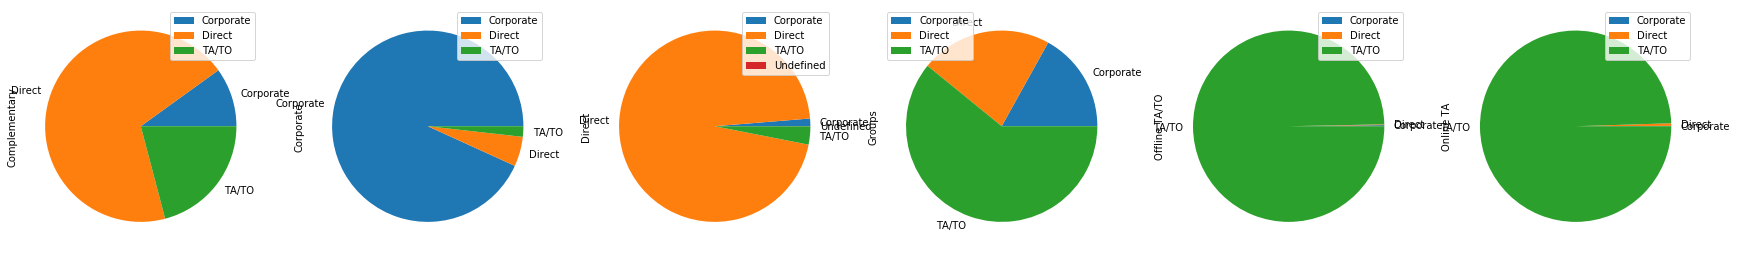

In [10]:
p_table3 = dataset.pivot_table( index = ['DistributionChannel'], aggfunc='count', values='ADR', columns=['MarketSegment']) 
p_table3.plot(kind='pie', subplots='true', figsize = (30, 30))

### Representing Country variation for each marketSegment


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000262A1F0A550>,
      dtype=object)

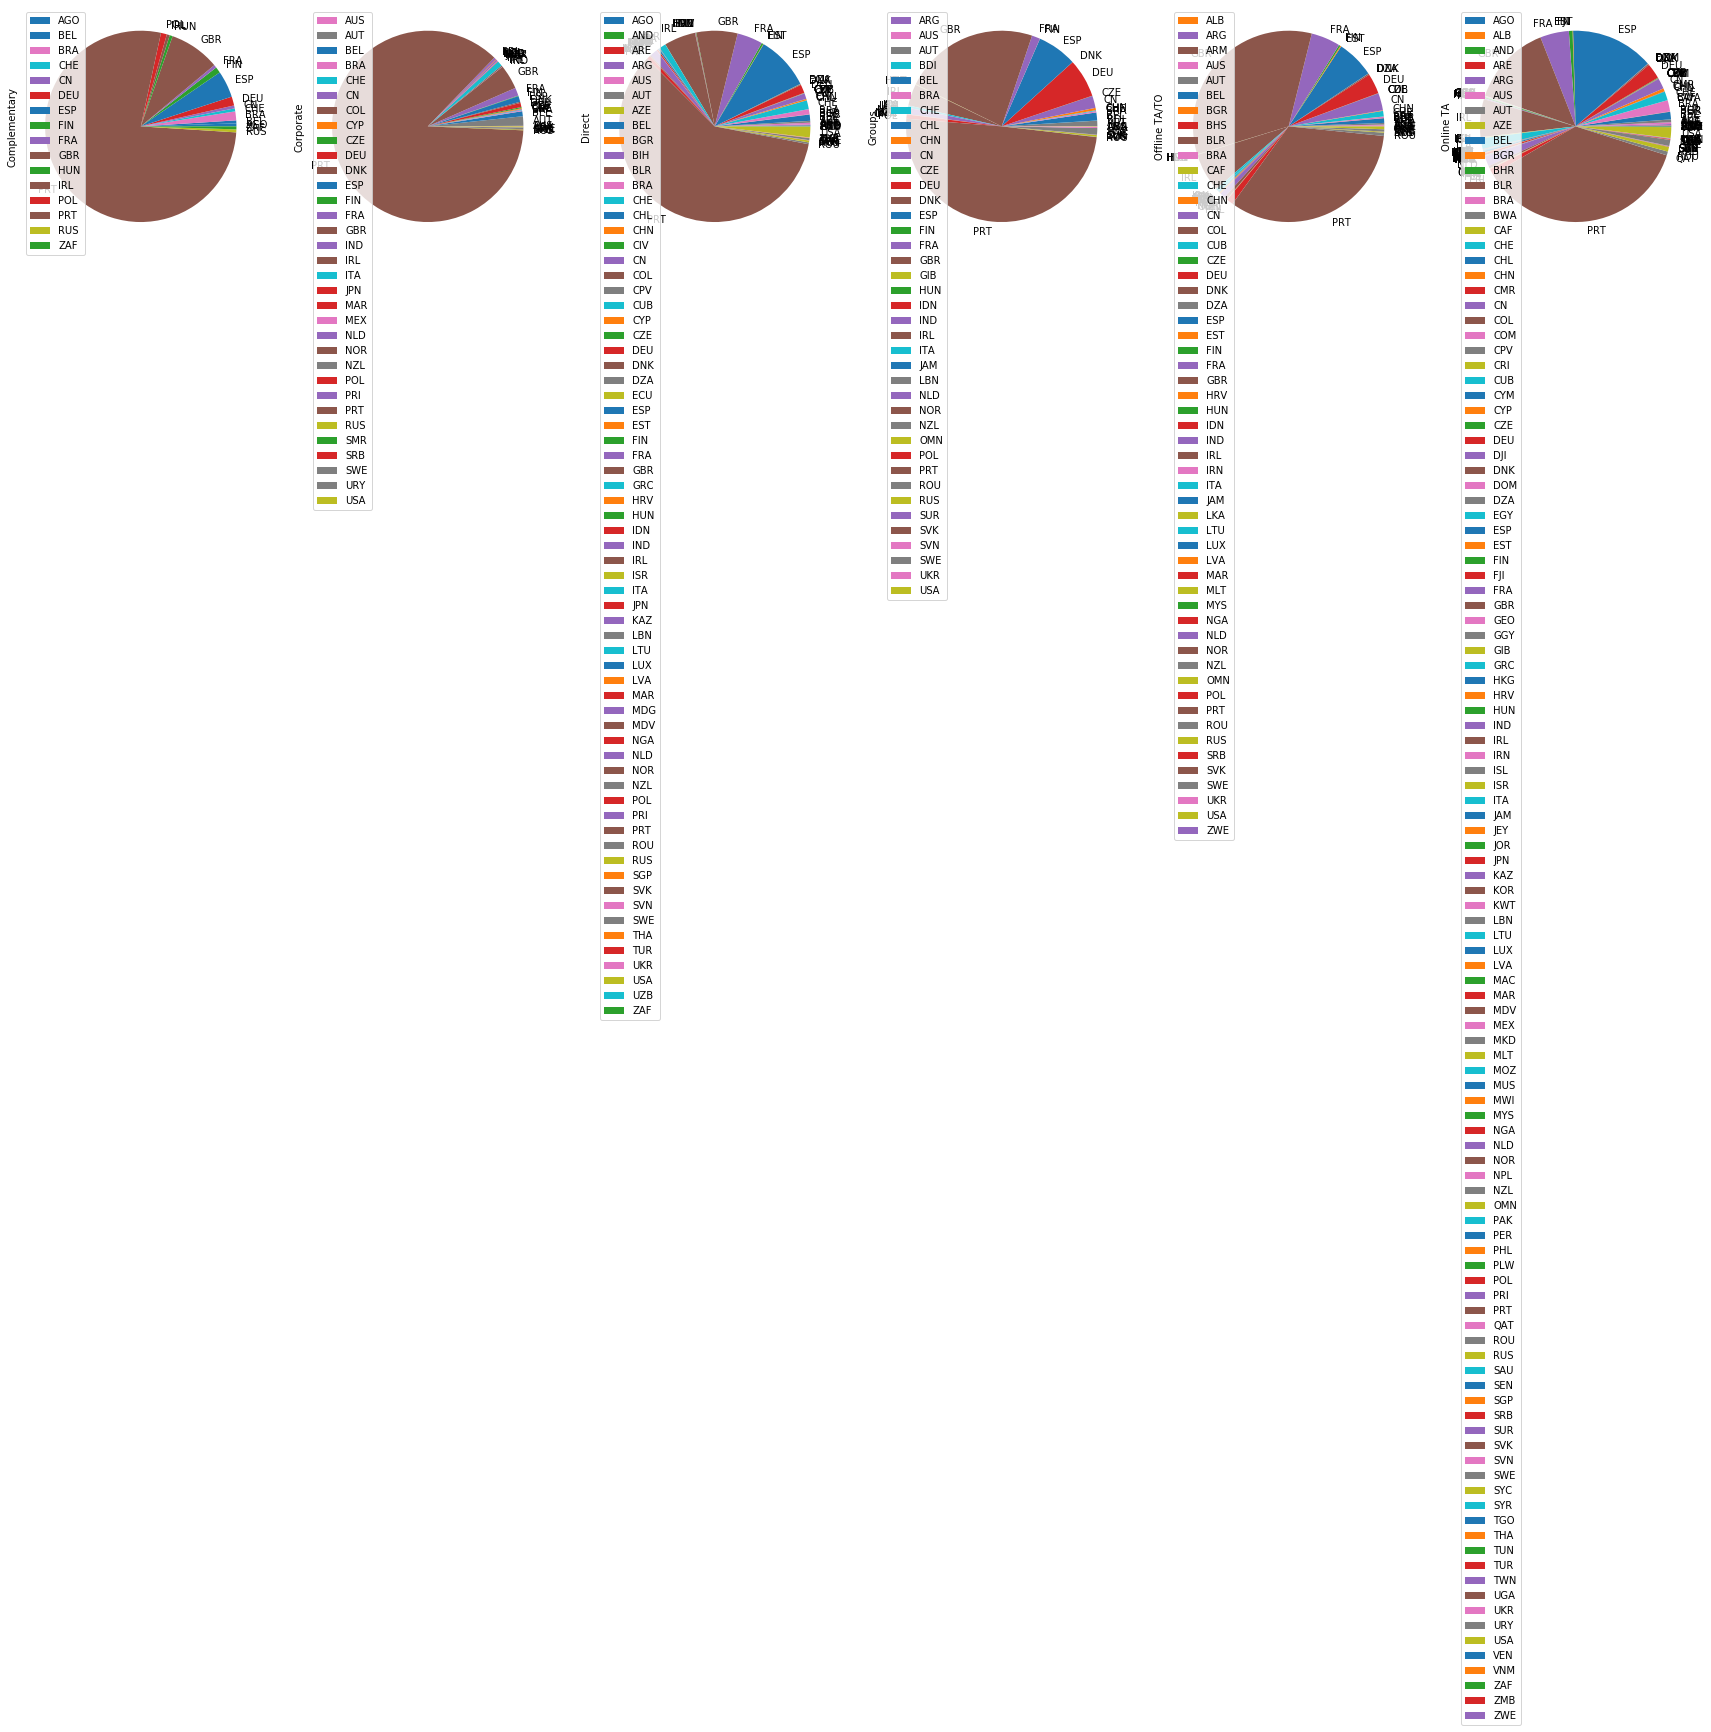

In [11]:
p_table4 = dataset.pivot_table( index = ['Country'], aggfunc='count', values='ADR', columns=['MarketSegment']) 
p_table4.plot(kind='pie', subplots='true', figsize = (30, 30))

### Variation of reserved room type with ADR

,ADR
ReservedRoomType,
A,23399
B,3
C,918
D,7433
E,4982
F,1106
G,1610
H,601
L,6


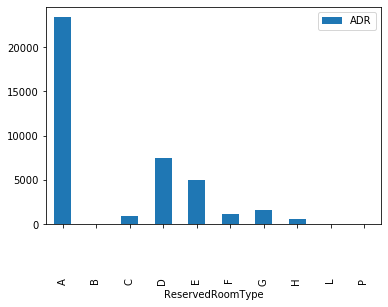

In [12]:
p_tabl5 = dataset.pivot_table( index = ['ReservedRoomType'], values = "ADR", aggfunc='count'  )
p_tabl5.plot(kind='bar')
p_tabl5

### Variation of assigned room type with ADR

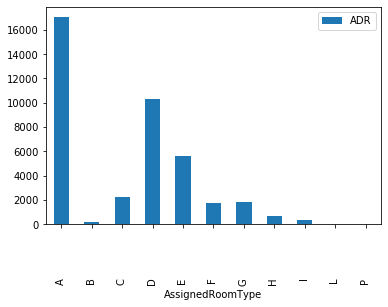

In [15]:
p_table5 = dataset.pivot_table( index = ['AssignedRoomType'], values = "ADR", aggfunc='count'  )
p_table5.plot(kind='bar')


### Arrival date variation with room type

AssignedRoomType,A,B,C,D,E,F,G,H,I,L,P
ArrivalDateMonth,,,,,,,,,,,
April,1491.0,12.0,207.0,946.0,587.0,137.0,147.0,47.0,35.0,NaN,NaN
August,1953.0,35.0,334.0,1160.0,716.0,249.0,289.0,124.0,34.0,NaN,NaN
December,1084.0,3.0,103.0,859.0,363.0,86.0,83.0,43.0,24.0,NaN,NaN
February,1353.0,3.0,129.0,971.0,377.0,105.0,105.0,36.0,23.0,NaN,1.0
January,768.0,3.0,57.0,839.0,299.0,93.0,84.0,28.0,22.0,NaN,NaN
July,1778.0,22.0,329.0,1062.0,713.0,222.0,289.0,115.0,42.0,1.0,NaN
June,1419.0,21.0,208.0,584.0,384.0,146.0,181.0,74.0,28.0,NaN,NaN
March,1424.0,11.0,165.0,955.0,439.0,146.0,126.0,34.0,36.0,NaN,NaN
May,1546.0,21.0,204.0,798.0,546.0,160.0,169.0,64.0,51.0,NaN,NaN


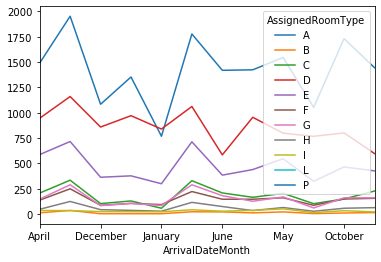

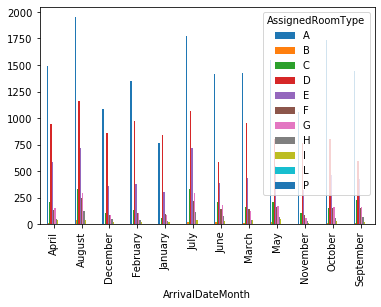

In [16]:
p_table6 = dataset.pivot_table( index = ['ArrivalDateMonth'], aggfunc='count', values='ADR', columns=['AssignedRoomType']) 
p_table6.plot()
p_table6.plot(kind = 'bar')
p_table6


### Arrival date variation with market segment

MarketSegment,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA
ArrivalDateMonth,,,,,,
April,20,230,496,988,491,1384
August,5,40,961,22,936,2930
December,32,143,467,489,413,1104
February,18,304,620,510,453,1198
January,16,191,522,227,264,973
July,12,109,872,63,936,2581
June,12,137,451,142,760,1543
March,17,269,526,784,558,1182
May,16,161,399,734,752,1497


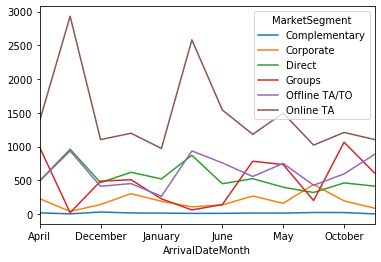

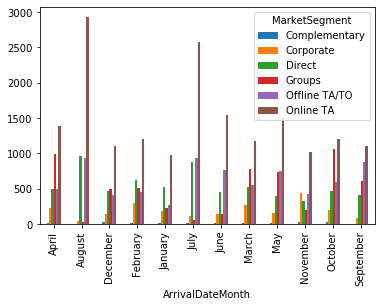

In [17]:
p_table6 = dataset.pivot_table( index = ['ArrivalDateMonth'], aggfunc='count', values='ADR', columns=['MarketSegment']) 
p_table6.plot()
p_table6.plot(kind = 'bar')
p_table6

### Arrival date variation with room type and market segment

AssignedRoomType A                                                       \
MarketSegment       Complementary Corporate Direct Groups Offline TA/TO   
ArrivalDateMonth                                                          
April                         2.0      83.0  113.0  595.0         222.0   
August                        2.0      12.0  280.0   14.0         429.0   
December                      6.0      60.0  104.0  402.0         166.0   
February                      3.0     138.0  179.0  421.0         217.0   
January                       NaN      49.0  147.0  129.0         128.0   
July                          4.0      47.0  233.0   46.0         452.0   
June                          2.0      82.0  156.0  110.0         335.0   
March                         7.0     140.0  138.0  435.0         280.0   
May                           3.0      82.0  109.0  511.0         296.0   
November                      4.0     205.0   88.0  145.0         203.0   
October                       3.0     118.0  170.0  687.0         301.0   
September                     2.0      49.0  106.0  424.0         405.0   

AssignedRoomType           B                                             ...  \
MarketSegment    Online TA        Corporate Direct Groups Offline TA/TO  ...   
ArrivalDateMonth                                                         ...   
April                476.0              2.0    3.0    3.0           1.0  ...   
August              1216.0              3.0    4.0    NaN           5.0  ...   
December             346.0              NaN    NaN    1.0           1.0  ...   
February             395.0              1.0    NaN    NaN           2.0  ...   
January              315.0              1.0    1.0    NaN           NaN  ...   
July                 996.0              1.0    5.0    NaN           7.0  ...   
June                 734.0              3.0    1.0    NaN           3.0  ...   
March                424.0              2.0    2.0    2.0           2.0  ...   
May                  545.0              NaN    6.0    2.0           3.0  ...   
November             408.0              2.0    1.0    1.0           NaN  ...   
October              453.0              NaN    3.0    3.0           3.0  ...   
September            459.0              NaN    1.0    3.0           6.0  ...   

AssignedRoomType H                          I                                  \
MarketSegment       Offline TA/TO Online TA    Complementary Corporate Direct   
ArrivalDateMonth                                                                
April                         NaN      31.0              NaN       3.0    1.0   
August                        1.0      90.0              NaN       NaN    4.0   
December                      NaN      34.0              NaN       2.0    3.0   
February                      NaN      28.0              1.0       7.0    4.0   
January                       NaN      19.0              NaN       3.0    3.0   
July                          1.0      88.0              2.0       2.0    7.0   
June                          3.0      50.0              NaN       NaN    5.0   
March                         1.0      23.0              NaN       4.0   10.0   
May                           3.0      34.0              NaN       5.0    4.0   
November                      NaN      10.0              NaN       NaN    2.0   
October                       1.0      30.0              2.0       4.0    3.0   
September                     1.0      42.0              NaN       NaN    5.0   

AssignedRoomType                                L                 \
MarketSegment    Groups Offline TA/TO Online TA           Direct   
ArrivalDateMonth                                                   
April               9.0          10.0      12.0              NaN   
August              NaN           6.0      24.0              NaN   
December            2.0           2.0      15.0              NaN   
February            NaN           5.0       6.0  

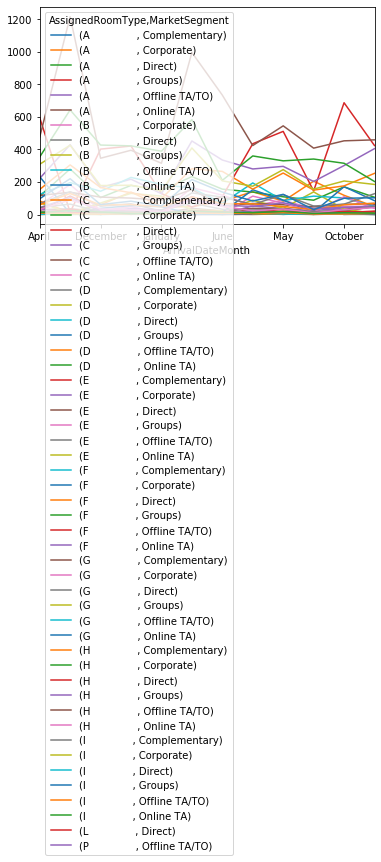

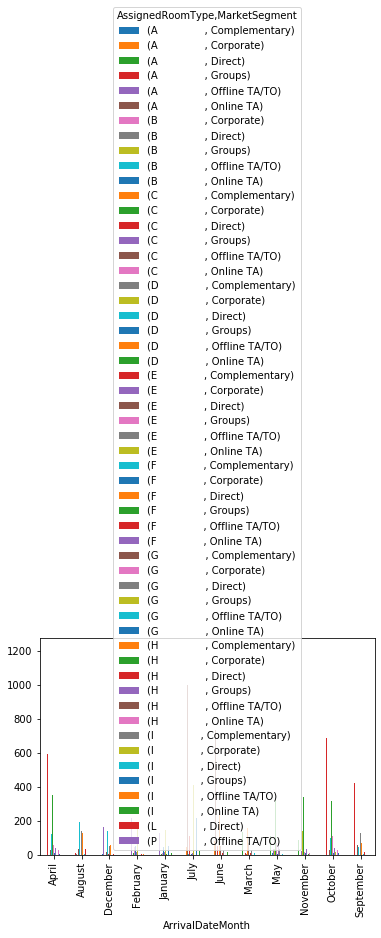

In [18]:
p_table7 = dataset.pivot_table( index = ['ArrivalDateMonth'], aggfunc='count', values='ADR', columns=['AssignedRoomType', 'MarketSegment']) 
p_table7.plot()
p_table7.plot(kind = 'bar')
p_table7


### Correlation Matrix

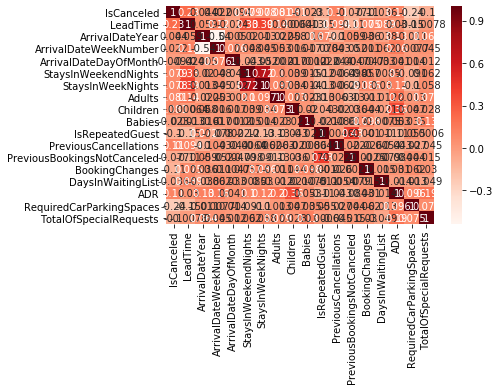

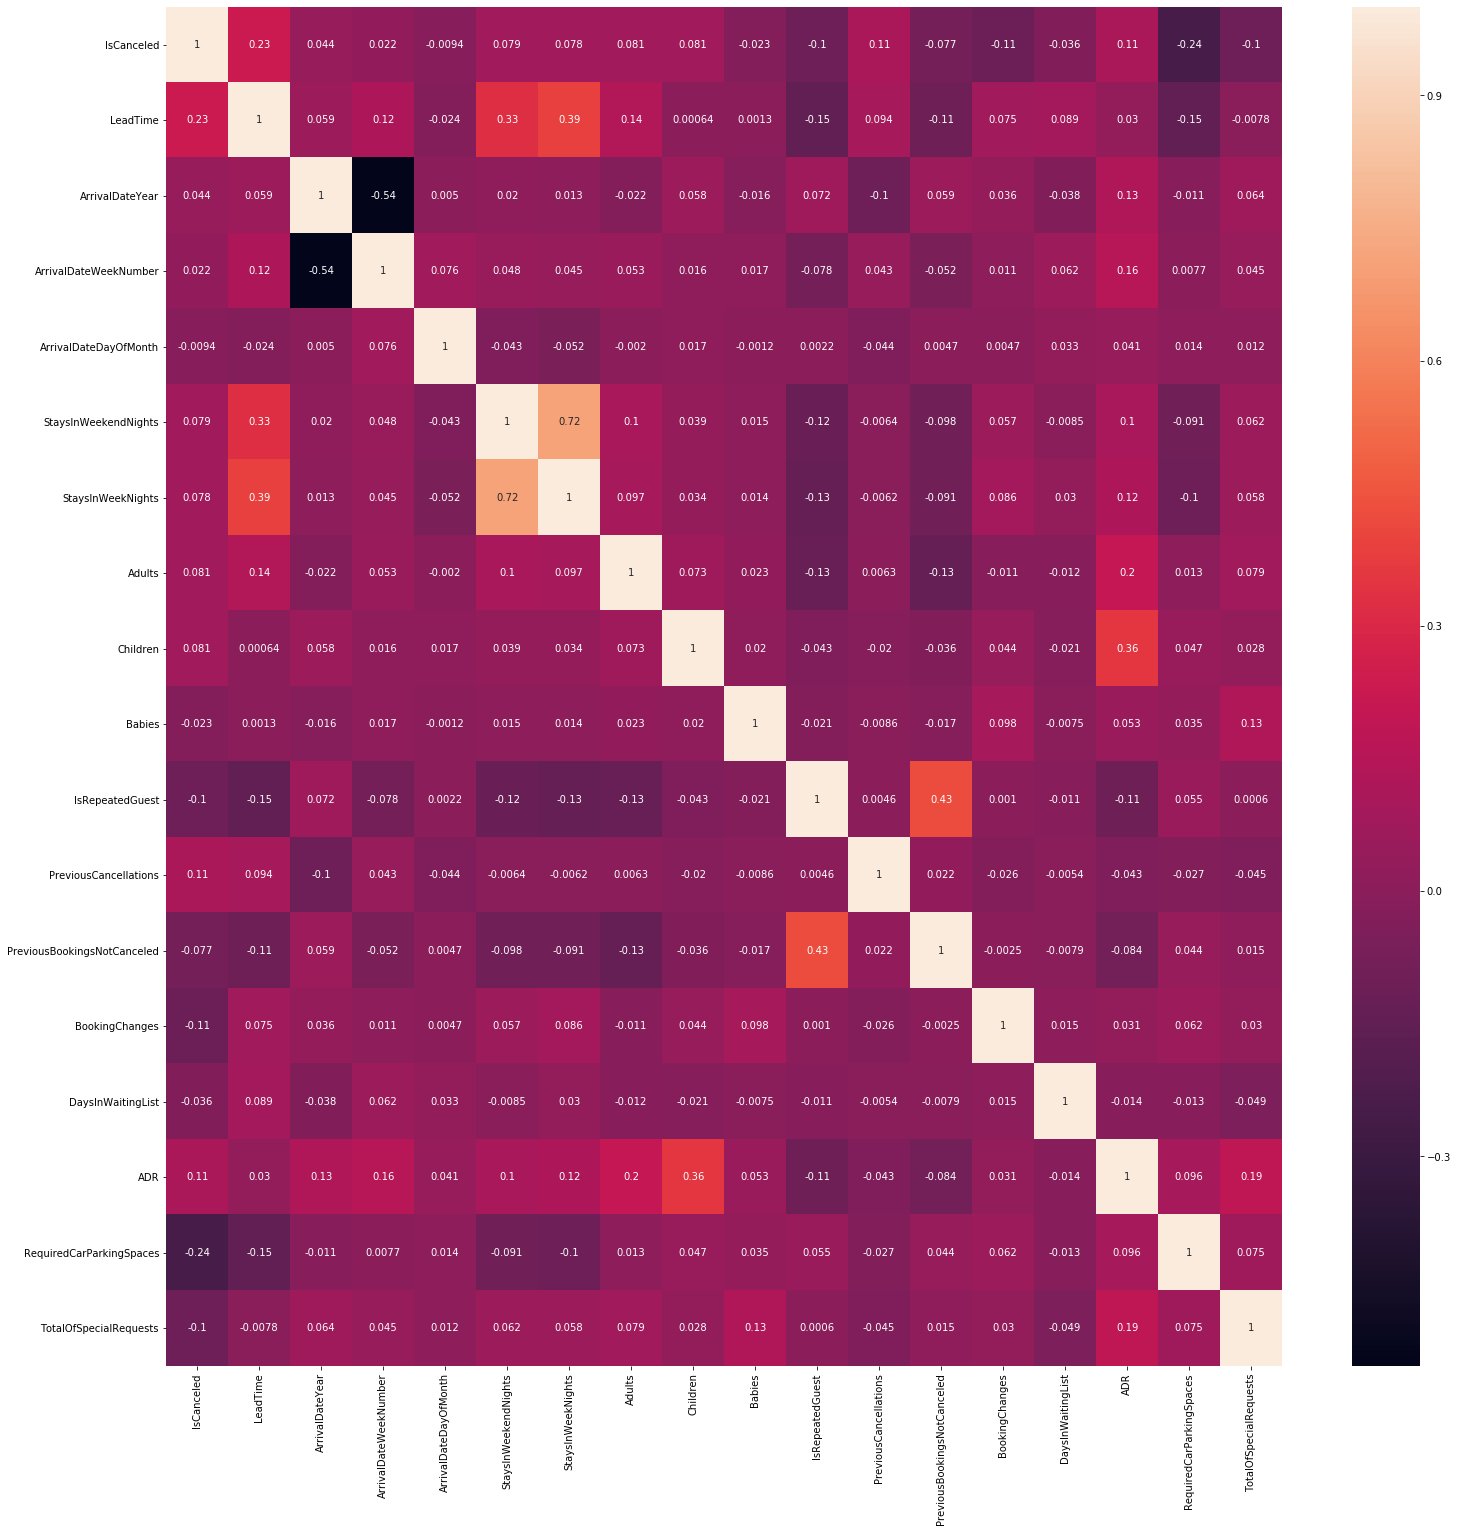

In [34]:
corrMatrix = dataset.corr()
sns.heatmap(corrMatrix, annot=True , cmap = plt.cm.Reds)
plt.figure(figsize = (25,25))
sns.heatmap(corrMatrix, annot=True)

### Regression Analysis and prediction

In [19]:
reggression = dataset[['AssignedRoomType', 'MarketSegment']]

In [20]:
reggression = dataset.pivot_table( index = ['ArrivalDateMonth'], aggfunc='count', values='ADR', columns=['AssignedRoomType','MarketSegment'])

In [21]:
reggression.columns

MultiIndex([('A               ', 'Complementary'),
            ('A               ',     'Corporate'),
            ('A               ',        'Direct'),
            ('A               ',        'Groups'),
            ('A               ', 'Offline TA/TO'),
            ('A               ',     'Online TA'),
            ('B               ',     'Corporate'),
            ('B               ',        'Direct'),
            ('B               ',        'Groups'),
            ('B               ', 'Offline TA/TO'),
            ('B               ',     'Online TA'),
            ('C               ', 'Complementary'),
            ('C               ',     'Corporate'),
            ('C               ',        'Direct'),
            ('C               ',        'Groups'),
            ('C               ', 'Offline TA/TO'),
            ('C               ',     'Online TA'),
            ('D               ', 'Complementary'),
            ('D               ',     'Corporate'),
            ('D               '

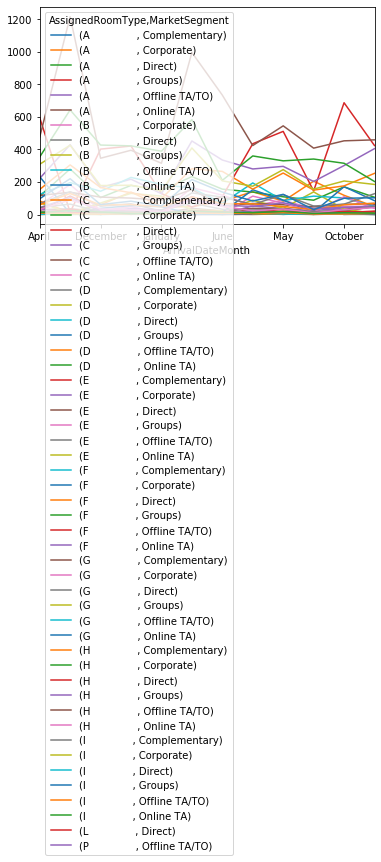

In [22]:
reggression.plot()

In [23]:
reggression[('A               ', 'Complementary')]

ArrivalDateMonth
April        2.0
August       2.0
December     6.0
February     3.0
January      NaN
July         4.0
June         2.0
March        7.0
May          3.0
November     4.0
October      3.0
September    2.0
Name: (A               , Complementary), dtype: float64

In [24]:
year_df = dataset.loc[dataset.index[dataset.ArrivalDateYear == 2016]]
year_df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
3738,0,109,2016,January,1,1,0,1,2,0,...,No Deposit,240,NULL,0,Transient-Party,59.94,0,1,Check-Out,2016-01-02
3739,0,109,2016,January,1,1,0,1,2,2,...,No Deposit,240,NULL,0,Transient-Party,116.10,1,1,Check-Out,2016-01-02
3740,1,2,2016,January,1,1,0,1,2,0,...,No Deposit,240,NULL,0,Transient,89.00,0,1,No-Show,2016-01-01
3741,0,88,2016,January,1,1,0,2,2,0,...,No Deposit,241,NULL,0,Transient,73.46,0,2,Check-Out,2016-01-03
3742,1,20,2016,January,1,1,0,2,2,2,...,No Deposit,240,NULL,0,Transient,119.00,0,0,Canceled,2015-12-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31820,0,132,2016,December,53,31,2,6,2,0,...,No Deposit,240,NULL,0,Transient,47.98,0,2,Check-Out,2017-01-08
31874,0,154,2016,December,53,29,3,8,2,0,...,No Deposit,240,NULL,0,Transient,47.54,0,3,Check-Out,2017-01-09
31896,0,147,2016,December,51,13,8,20,2,0,...,No Deposit,NULL,NULL,0,Transient,59.08,0,1,Check-Out,2017-01-10
31938,0,68,2016,December,53,29,4,10,2,0,...,No Deposit,464,NULL,0,Transient,80.14,0,1,Check-Out,2017-01-12


In [25]:
reggression = year_df.pivot_table(index = ['ArrivalDateMonth'], aggfunc='count', values='ADR', columns=['AssignedRoomType','MarketSegment'])
reggression

AssignedRoomType A                                                       \
MarketSegment       Complementary Corporate Direct Groups Offline TA/TO   
ArrivalDateMonth                                                          
April                         NaN      42.0   52.0  411.0         143.0   
August                        NaN       3.0  104.0    NaN         123.0   
December                      6.0      22.0   65.0  178.0          51.0   
February                      1.0      25.0   68.0  304.0         135.0   
January                       NaN      16.0   29.0   44.0          72.0   
July                          3.0      17.0   71.0   11.0         140.0   
June                          NaN      31.0   61.0   70.0         151.0   
March                         2.0      59.0   82.0  197.0         214.0   
May                           2.0      50.0   59.0  373.0         109.0   
November                      2.0      31.0   48.0   95.0          78.0   
October                       3.0      50.0   99.0  374.0         102.0   
September                     2.0      28.0   48.0  153.0         119.0   

AssignedRoomType           B                                             ...  \
MarketSegment    Online TA        Corporate Direct Groups Offline TA/TO  ...   
ArrivalDateMonth                                                         ...   
April                162.0              1.0    2.0    2.0           1.0  ...   
August               447.0              1.0    1.0    NaN           1.0  ...   
December             242.0              NaN    NaN    NaN           NaN  ...   
February             118.0              NaN    NaN    NaN           1.0  ...   
January               63.0              NaN    NaN    NaN           NaN  ...   
July                 341.0              NaN    2.0    NaN           3.0  ...   
June                 348.0              2.0    1.0    NaN           3.0  ...   
March                234.0              NaN    NaN    1.0           1.0  ...   
May                  239.0              NaN    4.0    2.0           2.0  ...   
November             289.0              NaN    1.0    1.0           NaN  ...   
October              287.0              NaN    3.0    2.0           NaN  ...   
September            263.0              NaN    NaN    1.0           2.0  ...   

AssignedRoomType H                                                \
MarketSegment              Direct Groups Offline TA/TO Online TA   
ArrivalDateMonth                                                   
April                         6.0    NaN           NaN      13.0   
August                       10.0    NaN           NaN      44.0   
December                      5.0    NaN           NaN      21.0   
February                      5.0    NaN           NaN      11.0   
January                       2.0    NaN           NaN       5.0   
July                          7.0    NaN           NaN      25.0   
June                          9.0    NaN           2.0      30.0   
March                         2.0    NaN           1.0      13.0   
May                           8.0    3.0           2.0      12.0   
November                      8.0    NaN           NaN       8.0   
October                      11.0    4.0           1.0      24.0   
September                    11.0    NaN           NaN      24.0   

AssignedRoomType I                                                       \
MarketSegment           Corporate Direct Groups Offline TA/TO Online TA   
ArrivalDateMonth                                                          
April                         3.0    1.0    8.0           8.0       6.0   
August                        NaN    1.0    NaN           2.0      16.0   
December                      2.0    3.0    1.0           2.0       8.0   
February                      3.0    1.0    NaN           1.0       3.0   
January                       2.0    1.0    NaN           2.0       8.0   
July                          1.0    2.0    1.0     

In [26]:
regression2 = reggression[('A               ', 'Complementary')]

In [27]:
regression2.reset_index()

,ArrivalDateMonth,A
,,Complementary
0,April,NaN
1,August,NaN
2,December,6.0
3,February,1.0
4,January,NaN
5,July,3.0
6,June,NaN
7,March,2.0
8,May,2.0


In [28]:
regression2.columns = ['month', 'val']
regression2

ArrivalDateMonth
April        NaN
August       NaN
December     6.0
February     1.0
January      NaN
July         3.0
June         NaN
March        2.0
May          2.0
November     2.0
October      3.0
September    2.0
Name: (A               , Complementary), dtype: float64

In [29]:
regression2 = regression2.fillna(0)

In [30]:
X = [regression2[0:11]]
X = np.asarray(X)
X = X.reshape(-1, 1)
X = X.transpose()
X

array([[0., 0., 6., 1., 0., 3., 0., 2., 2., 2., 3.]])

In [31]:
y = regression2[11:]
y = np.asarray(y)
y

array([2.])

In [32]:
reg = LinearRegression().fit(X, y)

In [33]:
reg.predict(X)

array([2.])